# Predicting the Past, United States Extension (Decay on) 

## Introduction
This is an add on of Predicting the Past, United States Extension where decay is now turned on. 
This add on includes comparisons between _CYCLUS_ output and CURIE data for the United States from 1968 to 2013 where decay is turned on for: 
 - Total spent fuel mass 
 - Mass of major isotopes in spent fuel 

The CURIE data is taken from UNF_ST&DARDS Unified Database and the Automatic Document Generator. 

The _CYCLUS_ data was generated by using published data of the commericial reactors that have operated in the United States. The _CYCLUS_ input file and simulation were generated in the original Predicting the Past, United States notebook. This notebook uses the SQL data file produced from the _CYCLUS_ simulation to do further analysis. 

Decay was turned on by adding 10 storage facilities to the input xml file that each take in consecutive ~ 5 years of spent fuel (with exception to 1st storage facility that takes ~ 10 years and 10th that takes everything after 2014) and outputs the spent fuel at year 2020. 

Most of the subsequent code is copied from united_states_extention.ipynb

** Import necessary libraries ** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import csv
import collections
import dateutil.parser as date
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import sys
import sqlite3 as lite
from matplotlib import cm
from pyne import nucname as nn
from IPython.display import Image, HTML, display
import seaborn as sns 

sys.path.append('../../../scripts/')
import analysis as an

** Run Cyclus simulation **

In [ ]:
!rm cyclus/united_states_decayon_underestm_33.sqlite
!cyclus -i ./cyclus/input/united_states_underestm_33.xml -o ./cyclus/united_states_decayon_underestm_33.sqlite --warn-limit 0

** Setting up to analyze sqlite file ** 

In [2]:
# Before this step, must download the output sqlite files from the fuel-cycles box. 
# fuel-cycle/cyclus_output/predicting_the_past_validation 
# and put into a directory named cyclus 

def get_cursor(file_name):
    """ Connects and returns a cursor to an sqlite output file

    Parameters
    ----------
    file_name: str
        name of the sqlite file

    Returns
    -------
    sqlite cursor
    """
    con = lite.connect(file_name)
    con.row_factory = lite.Row
    return con.cursor()


cursor_51 = get_cursor('cyclus/united_states_decayon_underestm.sqlite')
cursor_33 = get_cursor('cyclus/united_states_decayon_underestm_33.sqlite')

In [3]:
def get_timesteps(cur):
    """ Returns simulation start year, month, duration and
    timesteps (in numpy linspace).

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    init_year: int
        start year of simulation
    init_month: int
        start month of simulation
    duration: int
        duration of simulation
    timestep: list
        linspace up to duration
    """
    info = cur.execute('SELECT initialyear, initialmonth, '
                       'duration FROM info').fetchone()
    init_year = info['initialyear']
    init_month = info['initialmonth']
    duration = info['duration']
    timestep = np.linspace(0, duration - 1, num=duration)

    return init_year, init_month, duration, timestep

** Get total spent fuel produced after cooling in spent fuel pool until 2020** 

In [55]:
def total_spent_fuel_produced(cur): 
    """ Find timeseries of mass of spent fuel output by reactors 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    timeseries list of spent fuel output by reactors
    """
    coollist = ["cool_spent_uox1","cool_spent_uox2","cool_spent_uox3","cool_spent_uox4","cool_spent_uox5","cool_spent_uox6","cool_spent_uox7","cool_spent_uox8","cool_spent_uox9"]
    total_list = []
    
    for x in range(0,9):
        cool_spent_uox = coollist[x]
        
        init_yr, init_month, duration, timestep = get_timesteps(cur)
        spent_fuel = cur.execute('SELECT time, sum(quantity) FROM transactions '
                                 'INNER JOIN resources '
                                 'ON transactions.resourceid = resources.resourceid '
                                 'WHERE Commodity =:cool_spent_uox' # must specify isotope and pool
                                 ' GROUP BY time ',{"cool_spent_uox": cool_spent_uox}).fetchall()
        spent_fuel_list = an.get_timeseries(spent_fuel,duration,True)
        spent_fuel_total = np.sum(spent_fuel_list)
        total_list.append(spent_fuel_total)
        
    total_cum = np.cumsum(total_list)
    return total_cum 

total_spentfuel_33 = total_spent_fuel_produced(cursor_33)
total_spentfuel_51 = total_spent_fuel_produced(cursor_51)

array([ 1459.8340249 ,  7519.75698932, 15199.75297599, 25405.99952384,
       32505.91225087, 40005.80154411, 47205.72015509, 54105.54506496,
       60105.45228216])

** Get specific isotope composition from total spent fuel produced after cooling in spent fuel pool until 2020** 

In [65]:
def isotope_total_cum(cur,num):
    """ Find total isotopes present in spent fuel output by reactor for each cooling pool and sum cumulatively 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    num: nucid 
    
    Returns 
    -------
    list of isotopes in spent fuel output by reactors added cumulatively for each cooling pool
    """    
    
    coollist = ["cool_spent_uox1","cool_spent_uox2","cool_spent_uox3","cool_spent_uox4","cool_spent_uox5","cool_spent_uox6","cool_spent_uox7","cool_spent_uox8","cool_spent_uox9"]
    isotope_total_list = []
    
    for x in range(0,9):
        cool_spent_uox = coollist[x]
    
        init_yr, init_month, duration, timestep = get_timesteps(cur)
        isotopes = cur.execute('SELECT time, sum(quantity)*massfrac FROM transactions '
                               'INNER JOIN resources '
                               'ON transactions.resourceid = resources.resourceid '
                               'LEFT OUTER JOIN compositions '
                               'ON resources.qualid = compositions.qualid '
                               'WHERE Commodity =:cool_spent_uox AND nucid =:num ' # must specify isotope and pool
                               ' GROUP BY time ',{"cool_spent_uox": cool_spent_uox, "num":num}).fetchall()
        isotope_list = an.get_timeseries(isotopes,duration,True)
        isotope_total = np.sum(isotope_list)
        isotope_total_list.append(isotope_total)
    
    isotope_total_cum = np.cumsum(isotope_total_list)
    
    return isotope_total_cum

In [62]:
# he-4
ca40_51 = isotope_total_cum(cursor_51,20040000)
ca40_33 = isotope_total_cum(cursor_33,20040000)

2.4488284640074677e-05
0.00010079305624677665
0.00012882953840995427
0.00017034620642864196
0.00011737807932104
0.00012120941650834962
0.00012077613807000314
0.00011574210650671675
9.835210561918344e-05
5.321033812651935e-06
2.1901223022405362e-05
2.7993248987961137e-05
3.701437586040554e-05
2.5504985269842924e-05
2.633750065904395e-05
2.6243361661621e-05
2.5149528415289944e-05
2.1370871825127574e-05


In [ ]:
he4_51 = ca40_51
he4_33 = ca40_33

In [63]:
# Ra-226
ra226_51 = isotope_total_cum(cursor_51,882260000)
ra226_33 = isotope_total_cum(cursor_33,882260000)

9.606483958370052e-09
3.1475026834407244e-08
3.136471020208234e-08
3.136301374319794e-08
1.5714648803188747e-08
1.1198497959931798e-08
7.156382162099027e-09
3.942950036743371e-09
1.929348800150259e-09
6.944831617398102e-09
2.2611421021814872e-08
2.2303601388229337e-08
2.1944296768124115e-08
1.071676862463336e-08
7.3251806928738745e-09
4.358202300078867e-09
2.0963384262115815e-09
8.253040467620542e-10


In [64]:
# Ra-228
ra228_51 = isotope_total_cum(cursor_51,882280000)
ra228_33 = isotope_total_cum(cursor_33,882280000)

4.016322702853396e-15
1.439991854136319e-14
1.5736876764240258e-14
1.730515253264091e-14
9.54168486453071e-15
7.451293372932775e-15
5.13727923369986e-15
2.9159501829403046e-15
1.3321878625916613e-15
2.5965637284390796e-15
9.270627137201903e-15
1.0076324413762678e-14
1.0998270087990809e-14
5.999801483298618e-15
4.609595262151875e-15
3.0926187893436208e-15
1.6652069262532632e-15
6.943400565793939e-16


In [66]:
# Pb-206
pb206_51 = isotope_total_cum(cursor_51,822060000)
pb206_33 = isotope_total_cum(cursor_33,822060000)

In [67]:
# Pb-207
pb207_51 = isotope_total_cum(cursor_51,822070000)
pb207_33 = isotope_total_cum(cursor_33,822070000)

In [68]:
# Pb-208
pb208_51 = isotope_total_cum(cursor_51,822080000)
pb208_33 = isotope_total_cum(cursor_33,822080000)

In [69]:
# Pb-210
pb210_51 = isotope_total_cum(cursor_51,822100000)
pb210_33 = isotope_total_cum(cursor_33,822100000)

In [70]:
# Th-228
th228_51 = isotope_total_cum(cursor_51,902280000)
th228_33 = isotope_total_cum(cursor_33,902280000)

In [73]:
# Th-229
th229_51 = isotope_total_cum(cursor_51,902290000)
th229_33 = isotope_total_cum(cursor_33,902290000)

In [74]:
# Th-230
th230_51 = isotope_total_cum(cursor_51,902300000)
th230_33 = isotope_total_cum(cursor_33,902300000)

In [75]:
# Th-232
th232_51 = isotope_total_cum(cursor_51,902320000)
th232_33 = isotope_total_cum(cursor_33,902320000)

In [76]:
# Bi-209
bi209_51 = isotope_total_cum(cursor_51,832090000)
bi209_33 = isotope_total_cum(cursor_33,832090000)

In [77]:
# Ac-227
ac227_51 = isotope_total_cum(cursor_51,892270000)
ac227_33 = isotope_total_cum(cursor_33,892270000)

In [78]:
# Pa-231
pa231_51 = isotope_total_cum(cursor_51,912310000)
pa231_33 = isotope_total_cum(cursor_33,912310000)

In [ ]:
# u-232
u232_51 = isotope_total_cum(cursor_51,922320000)
u232_33 = isotope_total_cum(cursor_33,922320000)

In [ ]:
# u-233
u233_51 = isotope_total_cum(cursor_51,922330000)
u233_33 = isotope_total_cum(cursor_33,922330000)

In [79]:
# u-234
u234_51 = isotope_total_cum(cursor_51,922340000)
u234_33 = isotope_total_cum(cursor_33,922340000)

In [80]:
# u-235
u235_51 = isotope_total_cum(cursor_51,922350000)
u235_33 = isotope_total_cum(cursor_33,922350000)

In [ ]:
# U-236
u236_51= isotope_total_cum(cursor_51,922360000)
u236_33= isotope_total_cum(cursor_33,922360000)

In [ ]:
# U-238
u238_51= isotope_total_cum(cursor_51,922380000)
u238_33= isotope_total_cum(cursor_33,922380000)

In [ ]:
# np-237
np237_51 = isotope_total_cum(cursor_51,932370000)
np237_33 = isotope_total_cum(cursor_33,932370000)

In [ ]:
# pu-238
pu238_51 = isotope_total_cum(cursor_51,942380000)
pu238_33 = isotope_total_cum(cursor_33,942380000)

In [8]:
# Pu-239 
pu239_51 = isotope_total_cum(cursor_51,942390000)
pu239_33 = isotope_total_cum(cursor_33,942390000)

9.35330723506435
38.50274734615584
49.21864257335916
65.08776821918114
44.85452487596804
46.3241583517447
46.164033006245575
44.24506783969108
37.60075561793497
7.612177951689041
31.33578577279314
40.05749169780992
52.973536558852544
36.5066146950639
37.703253653912455
37.57347284032633
36.01215528506423
30.604571785018567


In [13]:
# Pu-240
pu240_51 = isotope_total_cum(cursor_51,942400000)
pu240_33 = isotope_total_cum(cursor_33,942400000)

4.591810677980021
18.889019615188168
24.12406906900075
31.864147194152135
21.925217022798904
22.599608166910226
22.466484982057917
21.466891890288522
18.190262491268662
3.4399366767190287
14.160992907513082
18.101493988882908
23.93461585094601
16.49022258538116
17.023992014923543
16.95582695389761
16.238794936919902
13.789758531536725


In [ ]:
# Pu-241
pu241_51 = isotope_total_cum(cursor_51,942410000)
pu241_33 = isotope_total_cum(cursor_33,942410000)

In [ ]:
# Pu-242
pu242_51 = isotope_total_cum(cursor_51,942420000)
pu242_33 = isotope_total_cum(cursor_33,942420000)

In [ ]:
# Pu-244
pu244_51 = isotope_total_cum(cursor_51,942440000)
pu244_33 = isotope_total_cum(cursor_33,942440000)

In [ ]:
# Am-241
am241_51= isotope_total_cum(cursor_51,952410000)
am241_33= isotope_total_cum(cursor_33,952410000)

In [ ]:
# Am-242
am242_51= isotope_total_cum(cursor_51,952420001)
am242_33= isotope_total_cum(cursor_33,952420001)

In [ ]:
# Am-243
am243_51= isotope_total_cum(cursor_51,952430000)
am243_33= isotope_total_cum(cursor_33,952430000)

In [ ]:
# Cm-242
cm242_51 = isotope_total_cum(cursor_51,962420000)
cm242_33 = isotope_total_cum(cursor_33,962420000)

In [ ]:
# Cm-243
cm243_51 = isotope_total_cum(cursor_51,962430000)
cm243_33 = isotope_total_cum(cursor_33,962430000)

In [ ]:
# Cm-244
cm244_51 = isotope_total_cum(cursor_51,962440000)
cm244_33 = isotope_total_cum(cursor_33,962440000)

In [ ]:
# Cm-245
cm245_51 = isotope_total_cum(cursor_51,962450000)
cm245_33 = isotope_total_cum(cursor_33,962450000)

In [ ]:
# Cm-246
cm246_51 = isotope_total_cum(cursor_51,962460000)
cm246_33 = isotope_total_cum(cursor_33,962460000)

In [ ]:
# Cm-247
cm247_51 = isotope_total_cum(cursor_51,962470000)
cm247_33 = isotope_total_cum(cursor_33,962470000)

In [ ]:
# Cm-248
cm248_51 = isotope_total_cum(cursor_51,962480000)
cm248_33 = isotope_total_cum(cursor_33,962480000)

In [ ]:
# Cm-250
cm250_51 = isotope_total_cum(cursor_51,962500000)
cm250_33 = isotope_total_cum(cursor_33,962500000)

In [ ]:
# cf-249
cf249_51 = isotope_total_cum(cursor_51,982490000)
cf249_33 = isotope_total_cum(cursor_33,982490000)

In [ ]:
# cf-250
cf250_51 = isotope_total_cum(cursor_51,982500000)
cf250_33 = isotope_total_cum(cursor_33,982500000)

In [ ]:
# cf-251
cf251_51 = isotope_total_cum(cursor_51,982510000)
cf251_33 = isotope_total_cum(cursor_33,982510000)

In [ ]:
# cf-252
cf252_51 = isotope_total_cum(cursor_51,982520000)
cf252_33 = isotope_total_cum(cursor_33,982520000)

In [ ]:
# h-3
h3_51 = isotope_total_cum(cursor_51,10030000)
h3_33 = isotope_total_cum(cursor_33,10030000)

In [81]:
# c-14
c14_51 = isotope_total_cum(cursor_51,60140000)
c14_33 = isotope_total_cum(cursor_33,60140000)

In [ ]:
# kr-81
kr81_51 = isotope_total_cum(cursor_51,360810000)
kr81_33 = isotope_total_cum(cursor_33,360810000)

In [ ]:
# kr-85
kr85_51 = isotope_total_cum(cursor_51,360850000)
kr85_33 = isotope_total_cum(cursor_33,360850000)

In [ ]:
# Sr-90
sr90_51= isotope_total_cum(cursor_51,380900000)
sr90_33= isotope_total_cum(cursor_33,380900000)

In [ ]:
# tc-99
tc99_51 = isotope_total_cum(cursor_51,430990000)
tc99_33 = isotope_total_cum(cursor_33,430990000)

In [ ]:
# i-129
i129_51 = isotope_total_cum(cursor_51,531290000)
i129_33 = isotope_total_cum(cursor_33,531290000)

In [ ]:
# Cs-134
cs137_51= isotope_total_cum(cursor_51,551370000)
cs137_33= isotope_total_cum(cursor_33,551370000)

In [ ]:
# Cs-135
cs137_51= isotope_total_cum(cursor_51,551370000)
cs137_33= isotope_total_cum(cursor_33,551370000)

In [ ]:
# Cs-137
cs137_51= isotope_total_cum(cursor_51,551370000)
cs137_33= isotope_total_cum(cursor_33,551370000)

## CURIE Data Analysis 

In [19]:
names = ['assembly_id','reactor_id', 'reactor_type', 'initial_uranium_kg','initial_enrichment','discharge_burnup','discharge_date','discharge_time','total_assembly_decay_heat_kw','name','evaluation_date','total_mass_g','total_radioactivity_curies']
df = pd.read_csv('SNF_nuclide_2020_07_01.dat',
                  sep='\s+',
                  index_col=False, 
                  names = names)

In [20]:
date_isotope_mass = df[['discharge_date','name','total_mass_g']]
date_mass = df[['discharge_date','total_mass_g']]

In [21]:
spent_fuel_mass = date_mass.groupby('discharge_date').sum()
spent_fuel_mass_cum = spent_fuel_mass.cumsum()
spent_fuel_mass_cum['total_mass_g'] = spent_fuel_mass_cum['total_mass_g'].apply(lambda x: x*0.000001)
spent_fuel_mass_cum = spent_fuel_mass_cum.rename(columns = {'total_mass_g':'total_mass_MTHM_CURIE'})
spent_fuel_mass_cum.index.names = ['discharge_date']

In [22]:
CURIE_isotope = date_isotope_mass.pivot_table(index='discharge_date',columns='name',aggfunc=sum)
CURIE_isotope_cum_all = CURIE_isotope.cumsum()

## Relative Error 

In [56]:
def relative_error_total(cyclus_list): 
    """ Find relative error between the total spent fuel output in 2014 for cyclus and udb data 
    
    Parameters 
    ----------
    cyclus_list: array of cumulative spent fuel mass 
    
    Returns 
    -------
    relative errors of spent fuel mass in 2014
    """   

    curie_list = spent_fuel_mass_cum.values
    cyclus_2014 = cyclus_list[-1] 
    curie_2014 = curie_list[-1]
    
    relative_error= (cyclus_2014-curie_2014)/curie_2014
    print(relative_error)
    
    return relative_error     

In [58]:
total_relative_error=relative_error_total(total_spentfuel_33)

[-0.11590094]


In [44]:
def relative_error_isotope(element,isotope,cyclus_list_51,cyclus_list_33): 
    """ Find relative error between the total isotopes present in spent fuel output in 2014 for cyclus and udb data 
    
    Parameters 
    ----------
    element: str of element name 
    isotope: str of isotope number 
    cyclus_list_51: array of cumulative isotope mass for burn up 51
    cyclus_list_33: array of cumulative isotope mass for burn up 33
    
    Returns 
    -------
    relative errors of the specified isotope for burn up of 51 and 33 GWd/tHM in 2014 
    """    

    isotopic = element + "-"+isotope 
    curie_list = CURIE_isotope_cum_all.loc[:,('total_mass_g', isotopic)]
    curie_list = curie_list.to_frame()
    curie_list = curie_list.multiply(0.000001)
    curie_list = curie_list.values
    #print(curie_list)
    
    cyclus_51_2014 = cyclus_list_51[-1]
    cyclus_33_2014 = cyclus_list_33[-1]
    curie_2014 = curie_list[-1]
    
    relative_error_51 = (cyclus_51_2014-curie_2014)/curie_2014
    relative_error_33 = (cyclus_33_2014-curie_2014)/curie_2014
    print(element,isotope,relative_error_51,relative_error_33)
    return relative_error_51, relative_error_33

In [45]:
pu239_51_relative_error,pu239_33_relative_error = relative_error_isotope("pu","239",pu239_51,pu239_33)
pu240_51_relative_error,pu240_33_relative_error = relative_error_isotope("pu","240",pu240_51,pu240_33)

pu 239 [-0.26734193] [-0.40369444]
pu 240 [0.03250001] [-0.22258769]


** CURIE and CYCLUS data on same plot for total spent fuel mass** 

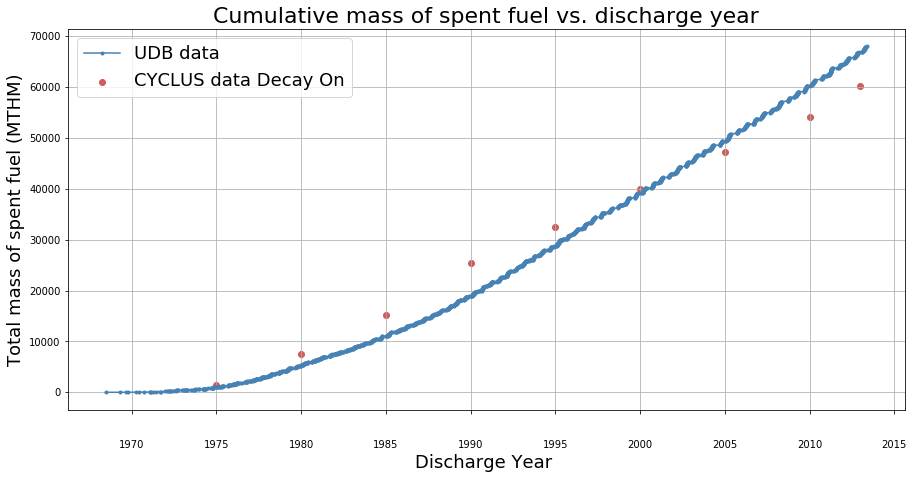

In [60]:
index = spent_fuel_mass_cum.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
data = spent_fuel_mass_cum.values
data2 = total_spentfuel_array_cum
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/cumulative_mass_spent_fuel_decayon.png', dpi=300)

** CURIE and CYCLUS data on same plot for total spent fuel mass for specific isotopes** 

In [ ]:
# Pu 239 
CURIE_isotope_single_pu239 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'pu-239')] # isotope name 
CURIE_isotope_single_pu239 = CURIE_isotope_single_pu239.to_frame()
CURIE_isotope_single_pu239 = CURIE_isotope_single_pu239.multiply(0.000001)
index = CURIE_isotope_single_pu239.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_pu239.columns.values)
data = CURIE_isotope_single_pu239.values
data2 = underestm_Pu239_array_cum
data3 = Pu239
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On, BU = 51', marker = "o")
ax.scatter(dts2, data3, color = 'orange', label='CYCLUS data Decay On BU = 33', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of Pu-239 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of Pu-239 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/Pu-239_cumulative_mass_spent_fuel_decayon.png', dpi=300)

In [ ]:
# Pu 240
CURIE_isotope_single_pu240 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'pu-240')] # isotope name 
CURIE_isotope_single_pu240 = CURIE_isotope_single_pu240.to_frame()
CURIE_isotope_single_pu240 = CURIE_isotope_single_pu240.multiply(0.000001)
index = CURIE_isotope_single_pu240.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_pu240.columns.values)
data = CURIE_isotope_single_pu240.values
data2 = underestm_Pu240_array_cum
data3 = Pu240_33
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.scatter(dts2, data3, color = 'orange', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of Pu-240 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of Pu-240 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/Pu-240_cumulative_mass_spent_fuel_decayon.png', dpi=300)

In [ ]:
# U 238
CURIE_isotope_single_u238 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'u-238')] # isotope name 
CURIE_isotope_single_u238 = CURIE_isotope_single_u238.to_frame()
CURIE_isotope_single_u238 = CURIE_isotope_single_u238.multiply(0.000001)
index = CURIE_isotope_single_u238.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_u238.columns.values)
data = CURIE_isotope_single_u238.values
data2 = underestm_U238_array_cum
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of U-238 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of U-238 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/U-238_cumulative_mass_spent_fuel_decayon.png', dpi=300)

In [ ]:
# Am-241
CURIE_isotope_single_am241 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'am-241')] # isotope name 
CURIE_isotope_single_am241 = CURIE_isotope_single_am241.to_frame()
CURIE_isotope_single_am241 = CURIE_isotope_single_am241.multiply(0.000001)
index = CURIE_isotope_single_am241.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_am241.columns.values)
data = CURIE_isotope_single_am241.values
data2 = underestm_Am241_array_cum
data3 = underestm33_Am241_array_cum
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)
col_no = -1

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.scatter(dts2, data3, color = 'orange', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of Am-241 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of Am-241 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/Am-241_cumulative_mass_spent_fuel_decayon.png', dpi=300)

In [ ]:
# Sr-90
CURIE_isotope_single_sr90 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'sr-90')] # isotope name 
CURIE_isotope_single_sr90 = CURIE_isotope_single_sr90.to_frame()
CURIE_isotope_single_sr90 = CURIE_isotope_single_sr90.multiply(0.000001)
index = CURIE_isotope_single_sr90.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_sr90.columns.values)
data = CURIE_isotope_single_sr90.values
data2 = underestm_Sr90_array_cum
data3 = Sr90_33
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.scatter(dts2, data3, color = 'orange', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of Sr-90 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of Sr-90 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/Sr-90_cumulative_mass_spent_fuel_decayon.png', dpi=300)

In [ ]:
# Cs-137
CURIE_isotope_single_cs137 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'cs-137')] # isotope name 
CURIE_isotope_single_cs137 = CURIE_isotope_single_cs137.to_frame()
CURIE_isotope_single_cs137 = CURIE_isotope_single_cs137.multiply(0.000001)
index = CURIE_isotope_single_cs137.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_cs137.columns.values)
data = CURIE_isotope_single_cs137.values
data2 = underestm_Cs137_array_cum
data3 = Cs137_33
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.scatter(dts2, data3, color = 'orange', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of Cs-137 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of Cs-137 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/Cs-137_cumulative_mass_spent_fuel_decayon.png', dpi=300)